# Entry 1: WAV files: Let's make some noise

I thought WAV might be a good next step, even though text files are arguably more basic and familiar, because I frankly think the nature of storing audio as data is more interesting to explain than mapping characters to codepoints.

A wav file contains audio, encoded as a series of samples with no compression.  The most typical form of wav works with uncompressed samples, although Microsoft dabbled with proprietary compression and extensions. In our case, the samples are in a format called Linear Pulse Code Modulation, or LPCM or PCM for short.

Here's an example of one from the [Open Speech Repository](http://www.voiptroubleshooter.com/open_speech/american.html).

[speech.wav](speech.wav)

These are Harvard Sentences, which are meant to contain a variety of vocal sounds so a listener can intuitively tell if something is wrong with the connection. They're used by phone companies, and there's actually some diagnostic phone numbers where you can hear recordings like this one.

## Context: What is stored?

Audio is a broad subject, but for this discussion, audio is a wave of pressure that human ears interpret as sound. Since it's a wave hitting our ears, we can think of it as a signal that has different levels of intensity at any moment.

![image.png](wave.png)
*"the source of the river is the clear spring," as a wave*

So, picture you have a microphone hooked up to a multimeter, and you can see the amount of energy hitting the microphone at any moment. Now imagine your perception and writing speed are amazingly fast. So every few tiny fractions of a second, you write down what's on the meter. Later, you can plot those logs on a graph to see the wave, or you can even figure out how to send those levels to a speaker to recreate the sound. That is the principle of digital audio recording.

For a wavefile comparable to a CD (which uses PCM as well), you need 44100 16 bit samples per second. In the analogy above, you'd need to write something down every 22.6 microseconds. Use durable paper and write legibly.

## Metadata

Wav files do indeed come with metadata. Here's a quick diagram from [the documentation for the soundfile++ library](http://soundfile.sapp.org/doc/WaveFormat/)
![image.png](wav-sound-format.gif)


There's several parts before the data called "subchunk." I'd have called them headers, but I guess I was too much of a baby when they were drafting this spec to give my opinion.

RIFF refers to Resource Interchange File Format, and I imagine the spec writers were having some fun mixing in a music term backronym. I never get to make backronyms. Lucky ducks. RIFF shows up in a couple formats' metadatas. The ASCII bytes for RIFF are also the first magic constant.

And then the riff says the size of the rest of the file, and the ASCII constant `WAVE`, making it official what type of multimedia file this is.

The next part is the fmt subchunk, which starts with an ASCII constant `fmt`, the length of the rest of this subchunk, and a description of all kinds of things to do with the audio samples. We have bytes for AudioFormat (1 for PCM, and other numbers for schemes I won't cover), NumChannels (is it Stereo, Mono, or something else?), SampleRate, ByteRate, BlockAlign (the number of bytes in each sample), and BitsPerSample.

And finally, there's the data subchunk, with the ASCII constant `data`, the remaining size, and then the rest of the bytes are the audio samples.

## The Data

After the above, it's relatively easy to picture a CPU-bound audio program on a system with no hardware buffer. Create a loop to load the number of bytes for each sample (BlockAlign), divide those bytes into channels by NumChannels, send those samples to the speakers, and then wait 1/SampleRate seconds to do it again.

Of course, that's naive and a bit of garbage collecting or OS thread scheduling would probably create some nasty skips and pops. A smarter program would load a buffer in memory in one loop, and create a tighter loop to manage sending buffered data to the soundcard, either using multiple threads or something like an event loop. It's a producer consumer problem.

But in the modern computer world, sound cards manage playing an audio buffer. So that's much easier.

## Let's read it ourselves
First, let's open the file:

In [1]:
with open("speech.wav", "rb") as f:
    wav = f.read()
    
print(wav[0:4])

b'RIFF'


So now it's in memory.

In [2]:
import struct
riff_chunk = wav[0:12]
struct.unpack("4si4s", riff_chunk)

(b'RIFF', 524592, b'WAVE')

And the struct.unpack function is useful for working with bytes! Just feed it a string of bytes and a series of objects in those bytes. So we have a four character string (`4s`), a four byte integer(`i`), and another 4 character string.

Let's interpret the `fmt` chunk

In [3]:
# get the length of the fmt header
fmt_len = struct.unpack("i", wav[16:20])
# untuple fmt_len, add 8 bytes for `fmt ` text and size of the size integer
fmt_len = fmt_len[0] + 8

fmt_chunk = wav[12:12+fmt_len]
fmt = struct.unpack("4sihhiihh", fmt_chunk)
print("""Check out this cool wav! It's got a {} subchunk that's {} plus 8 bytes long, 
{} as its format, meaning PCM, {} channel(s), {} samples per second, a byterate of {}, 
{} bytes per block of samples, and {} bits per sample (on each channel).
I personally think it's neat...""".format(*fmt))

Check out this cool wav! It's got a b'fmt ' subchunk that's 16 plus 8 bytes long, 
1 as its format, meaning PCM, 1 channel(s), 8000 samples per second, a byterate of 16000, 
2 bytes per block of samples, and 16 bits per sample (on each channel).
I personally think it's neat...


Now that we have all of that, we have the details we need for the rest of the decoding. This being an IPython notebook, I probably shouldn't try to play sound, since that wouldn't transfer to IPython. But maybe I can make a quick and dirty plot of the wave

Text(0,0.5,'amplitude')

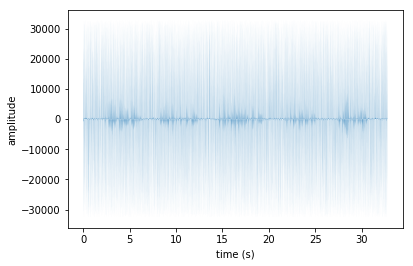

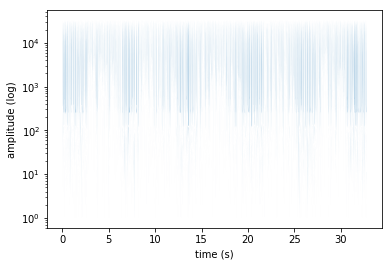

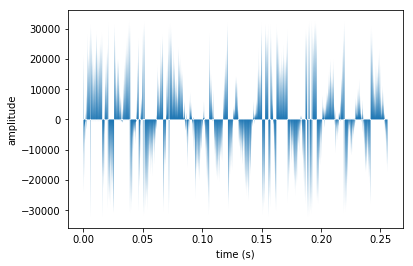

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#hardcoding this for a mono stream of 16 bit samples
data = wav[12+fmt_len+8:]
samples = [struct.unpack("h", data[i:i+fmt[-2]])[0] for i in range(0, len(data)//fmt[-2])]
time = np.arange(len(samples))/fmt[4]
# print(time)
# I'm unfamiliar with matplotlib, and saw this Gist which inspired the following code: 
# https://gist.github.com/leouieda/9043213
plt.fill_between(time, samples)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.figure(2)
plt.fill_between(time, samples)
plt.xlabel('time (s)')
plt.ylabel('amplitude (log)')
plt.yscale("log")
plt.figure(3)
samples = np.array(samples)
plt.fill_between(time[0:len(time)//128], samples[0:len(samples)//128])
plt.xlabel('time (s)')
plt.ylabel('amplitude')
#plt.yscale("log")

And we have a chart of the entire file, a log version of that chart, and a quarter secondish sample to show more of the wav shape. Thanks to this [GitHub Gist](https://gist.github.com/leouieda/9043213) for pushing me in the right direction on how to plot this.

## Conculsion

Wav files are really simple, and about as simple as multimedia files can be. You have chunks of values in one big array, with no compression. Next time, I plan to demonstrate BMP, a format that is also rather simple, but which adds a second dimension to the data, and matters of how to encode/store color.